In [35]:
import tensorflow as tf
import numpy as np
import os
import time

### SOURCE TEXT LOADING
- loading .txt
- printing the beginning, number of characters, number of unique characters
    

In [36]:
with open("ring.txt", "r") as f:
    source = f.read()
print(source[:300])

THE  FELLOWSHIP 
OF  THE  RING 


BEING  THE  FIRST  PART 
OF 

The  Lord  of  the  Rings 


BOOK  ONE 


Chapter  I 


A  LONG-EXPECTED  PARTY 


When  Mr.  Bilbo  Baggins  of  Bag  End  announced  that  he 
would  shortly  be  celebrating  his  eleventy-first  birthday  with 
a  party  of  special


In [37]:
print ('{} characters'.format(len(source)))

1145534 characters


In [38]:
vocab = sorted(set(source))
print ('{} unique characters'.format(len(vocab)))

88 unique characters


In [39]:
# unique characters to indices mapping
char2index = {u:i for i, u in enumerate(vocab)}
index2char = np.array(vocab)

text_as_int = np.array([char2index[c] for c in source])

print(text_as_int)

[45 33 30 ...  1  0  0]


In [40]:
print ('{} -- characters mapped to int -- > {}'.format(repr(source[:13]), text_as_int[:13]))

'THE  FELLOWSH' -- characters mapped to int -- > [45 33 30  1  1 31 30 37 37 40 48 44 33]


### DATASET PREPROCESSING
- character to index mapping and converting text to numerical representation
- defining max input sequence length
- creating TensorFlow Dataset from the source
- creating batches from dataset
- input-target split function (:-1 is input, and last element is expected value)
- applying input-target split function to each batch

In [41]:
seq_length = 100
examples_per_epoch = len(source)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(index2char[i.numpy()])


T
H
E
 
 


In [42]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(index2char[item.numpy()])))

'THE  FELLOWSHIP \nOF  THE  RING \n\n\nBEING  THE  FIRST  PART \nOF \n\nThe  Lord  of  the  Rings \n\n\nBOOK  ON'
'E \n\n\nChapter  I \n\n\nA  LONG-EXPECTED  PARTY \n\n\nWhen  Mr.  Bilbo  Baggins  of  Bag  End  announced  tha'
't  he \nwould  shortly  be  celebrating  his  eleventy-first  birthday  with \na  party  of  special  m'
'agnificence,  there  was  much  talk  and \nexcitement  in  Hobbiton. \n\nBilbo  was  very  rich  and  v'
'ery  peculiar,  and  had  been  the \nwonder  of  the  Shire  for  sixty  years,  ever  since  his  re'


In [43]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

### PARAMETERS
- training parameters & data shuffling
- model hyperparameters

In [44]:
BATCH_SIZE = 512
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset element_spec=(TensorSpec(shape=(512, 100), dtype=tf.int64, name=None), TensorSpec(shape=(512, 100), dtype=tf.int64, name=None))>

In [45]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 300 #256

# Number of RNN units
rnn_units1 = 1024
rnn_units2 = 1024
rnn_units=[rnn_units1, rnn_units2]
print(vocab_size)

88


### BUILDING MODEL
- GRU, LSTM, RNN, with Conv1

In [46]:
# ORIGINAL GRU
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units1,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.GRU(rnn_units2,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [47]:
# # LSTM
# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Embedding(vocab_size, embedding_dim, 
#                                   batch_input_shape=[batch_size, None]),
#         tf.keras.layers.LSTM(rnn_units1,
#                              return_sequences=True,
#                              stateful=True,
#                              recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.LSTM(rnn_units2,
#                              return_sequences=True,
#                              stateful=True,
#                              recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.Dense(vocab_size)
#     ])
#     return model

In [48]:
# # RNN
# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Embedding(vocab_size, embedding_dim, 
#                                   batch_input_shape=[batch_size, None]),
#         tf.keras.layers.SimpleRNN(rnn_units1,
#                                   return_sequences=True,
#                                   stateful=True,
#                                   recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.SimpleRNN(rnn_units2,
#                                   return_sequences=True,
#                                   stateful=True,
#                                   recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.Dense(vocab_size)
#     ])
#     return model


In [49]:
# # dodanie Conv1
# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Embedding(vocab_size, embedding_dim, 
#                                   batch_input_shape=[batch_size, None]),
#         tf.keras.layers.Conv1D(filters=128, 
#                                kernel_size=5, 
#                                activation='relu', 
#                                padding='same'),
#         tf.keras.layers.GRU(rnn_units1,
#                             return_sequences=True,
#                             stateful=True,
#                             recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.GRU(rnn_units2,
#                             return_sequences=True,
#                             stateful=True,
#                             recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.Dense(vocab_size)
#     ])
#     return model


In [50]:
model = build_model(
  vocab_size = vocab_size,
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (512, None, 300)          26400     
                                                                 
 gru_4 (GRU)                 (512, None, 1024)         4073472   
                                                                 
 gru_5 (GRU)                 (512, None, 1024)         6297600   
                                                                 
 dense_2 (Dense)             (512, None, 88)           90200     
                                                                 
Total params: 10,487,672
Trainable params: 10,487,672
Non-trainable params: 0
_________________________________________________________________


### MODEL TRAINING
- optimizer & loss function declaration
- compilation
- epochs number
- launching the training

In [52]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [53]:
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [54]:
checkpoint_dir = './checkpoints_GRU'        # TODO: remember to choose proper directory
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [55]:
EPOCHS=20

In [56]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20


22/22 [==============================] - 237s 11s/step - loss: 3.8696 - accuracy: 0.2056
Epoch 2/20
22/22 [==============================] - 221s 10s/step - loss: 2.6716 - accuracy: 0.3245
Epoch 3/20
22/22 [==============================] - 224s 10s/step - loss: 2.3525 - accuracy: 0.3741
Epoch 4/20
22/22 [==============================] - 202s 9s/step - loss: 2.1299 - accuracy: 0.4214
Epoch 5/20
22/22 [==============================] - 196s 9s/step - loss: 1.9785 - accuracy: 0.4446
Epoch 6/20
22/22 [==============================] - 201s 9s/step - loss: 1.8720 - accuracy: 0.4718
Epoch 7/20
22/22 [==============================] - 221s 10s/step - loss: 1.7815 - accuracy: 0.4952
Epoch 8/20
22/22 [==============================] - 240s 11s/step - loss: 1.7028 - accuracy: 0.5152
Epoch 9/20
22/22 [==============================] - 231s 10s/step - loss: 1.6339 - accuracy: 0.5311
Epoch 10/20
22/22 [==============================] - 213s 10s/step - loss: 1.5678 - accuracy: 0.5475
Epoch 11/20
2

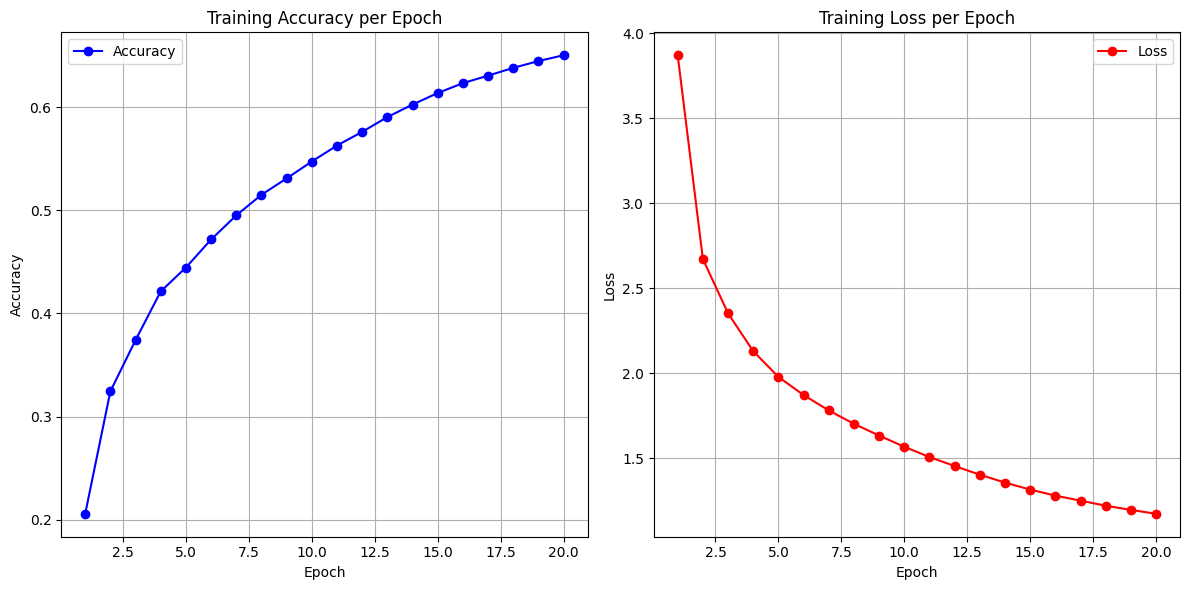

In [73]:
import matplotlib.pyplot as plt

# Pobranie wartości strat i dokładności z historii
loss = history.history['loss']
accuracy = history.history['accuracy']
epochs = range(1, len(loss) + 1)

# Wykres strat i dokładności
plt.figure(figsize=(12, 6))

# Wykres strat
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, marker='o', label='Loss', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### RESULTS
- bulding the model and applying saved weights
- text generation function
- generate text based on the provided beginning

In [57]:
latest_check= tf.train.latest_checkpoint(checkpoint_dir)

In [58]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(latest_check)

model.build(tf.TensorShape([1, None]))

In [59]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (1, None, 300)            26400     
                                                                 
 gru_6 (GRU)                 (1, None, 1024)           4073472   
                                                                 
 gru_7 (GRU)                 (1, None, 1024)           6297600   
                                                                 
 dense_3 (Dense)             (1, None, 88)             90200     
                                                                 
Total params: 10,487,672
Trainable params: 10,487,672
Non-trainable params: 0
_________________________________________________________________


In [60]:
def generate_text(model, start_string):

  num_generate = 1000
  input_eval = [char2index[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  scaling = 0.5

  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predictions = predictions / scaling
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(index2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [61]:
print(generate_text(model, start_string=u"Harry killed Ron "))

Harry killed Ron  the  made  of  Sauron,  ‘and  they  could  see  the  trees  that  went  only  to  the  boats  and  great  than  it  as  he  saw  that  he  opened  to  the  contlent  of  the  night  of  the  woods  of  the  trees,  and  the  river  of  the  Ring  of  the  land  of  the  wind  was  still  the  light  of  the  hills.  He  was  been  said  into  the  flames  of  the  Shire.  The  last  the  stars  of  the  fail  of  the  world  of  the  wind  hand  and  strong  of  the  others  happened  to  the  shade  of  the  Minas  Tirith  some  of  the  wind  was  a  breatherthere  was  a  the  Ring,  and  the  Ring  the  sun  was  called  him  for  a  long  most  of  the  land  by  some  of  the  world  below  the  stood  and  fair,  and  the  hobbits  and  the  Ring  where  the  wind  was  seemed  to  see 
the  long  the  tree- 
time  to  the  colled  before  them  to  the  hill  of  the  ground.  I  was  a  corner  was  many  more  that  he  come  to  the  eastern  of  the  Ring 

In [62]:
print(generate_text(model, start_string=u"Manchaster Uniter just lost the war on Anfield fighting"))

Manchaster Uniter just lost the war on Anfield fighting  of  the  shadow  of  the  pile  of  the  stone  of  the  North.  One  that  is  soon  to  the  stars  and  the  sound  of  the  boats.  The  land  of  the  story,  and  he  letter  that  the  boats  and  great  days  of  the  hobbits  and  places  of  the  doors  of  the  west  of  the  stars  were  I  should  see  where  they  came  only  to  the  first  that  had  pleased  and  drawn  a  chance  of  the  middle  of  the  road  was  now  shone  will  be  a  black  power  of  the  River  change  and  the  gate  of  the  Shire,  and  the  Ores  of  the  wind  he  stood  and  light  from  Hobbits  and  the  wind  of  the  stream  of  the  stone  of  the  hobbits  had  raned  the  hobbits.  Frodo  from  the  Ores  were  seemed  to  the  hobbits  and  come  on  the  widard  was  now  stood  and  something  was  before  the  beats.  Not  the  hills  of  the  water  of  the  Shire;  but  the  sun  should  not  soon  as  we  could  not 

---

In [63]:
def calculate_cross_entropy_loss(model, test_sequences):
    total_loss = 0
    total_steps = 0
    
    for sequence in test_sequences:
        input_seq = sequence[:-1]
        target_seq = sequence[1:]
        
        input_seq = tf.expand_dims(input_seq, 0)
        
        predictions = model(input_seq)
        
        loss = tf.keras.losses.sparse_categorical_crossentropy(target_seq, predictions[0], from_logits=True)
        
        total_loss += tf.reduce_sum(loss).numpy()
        total_steps += len(target_seq)
    
    avg_loss = total_loss / total_steps
    return avg_loss

In [64]:
# tutaj można załadować inną część tolkiena albo hobbita
first_10_sequences = list(sequences.take(2))

In [65]:
avg_loss = calculate_cross_entropy_loss(model, first_10_sequences)
avg_loss

1.1381225967407227

In [66]:
perplexity = np.exp(avg_loss)
perplexity

3.1209036669906842